# Инициализация необходимых библиотек

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np
import pandas as pd
import joblib
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from scipy.special import expit

# Загрузка данных для обучения модели

In [68]:
# Загрузка данных
df = pd.read_csv("data/Готовые данные.csv")

# Просмотр первых строк и структуры данных
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812 entries, 0 to 1811
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   comment                             1812 non-null   object 
 1   id                                  1812 non-null   float64
 2   rating                              1812 non-null   float64
 3   Вопрос решен                        1812 non-null   int64  
 4   Качество выполненной работы         1812 non-null   int64  
 5   Компетентность работника в общение  1812 non-null   int64  
 6   Не удовлетворен                     1812 non-null   int64  
 7   Скорость выполненной работы         1812 non-null   int64  
 8   Не понравился результат             1812 non-null   int64  
 9   Не понравилось качество             1812 non-null   int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 141.7+ KB


(                                        comment         id  rating  \
 0                                       спасибо  2945792.0     5.0   
 1                                      спасибо!  3234340.0     5.0   
 2                                      Отлично   3380332.0     5.0   
 3  Благодарю за оперативное решение проблемы !   3381812.0     5.0   
 4         Прекрасный специалист! Побольше таких  3461991.0     5.0   
 
    Вопрос решен  Качество выполненной работы  \
 0             1                            0   
 1             1                            0   
 2             1                            0   
 3             1                            0   
 4             1                            1   
 
    Компетентность работника в общение  Не удовлетворен  \
 0                                   0                0   
 1                                   0                0   
 2                                   0                0   
 3                                   0  

### Разделение данных для обучения моделей

In [69]:
X_raw = df["comment"]
y = df.iloc[:, 3:]


# Векторизация текста
vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(X_raw)
X = X.toarray()
y_array = y.values.astype(int)

# Стратифицированное разбиение (70% train, 30% test)
X_train, y_train, X_test, y_test = iterative_train_test_split(
    X, y_array, test_size=0.3
)

# Преобразуем обратно в DataFrame, если нужно
X_train_raw = X_raw.iloc[np.ravel(np.where(np.isin(X, X_train).all(axis=1)))].reset_index(drop=True)
X_test_raw = X_raw.iloc[np.ravel(np.where(np.isin(X, X_test).all(axis=1)))].reset_index(drop=True)

### Logistic Regression


Logistic Regression
Label                                       ROC-AUC         F1
-----------------------------------------------------------------
Вопрос решен                                  0.849      0.953
Качество выполненной работы                   0.680      0.495
Компетентность работника в общение            0.742      0.559
Не удовлетворен                               0.857      0.658
Скорость выполненной работы                   0.902      0.889
Не понравился результат                       0.746      0.419
Не понравилось качество                       0.798      0.554
-----------------------------------------------------------------
Average ROC-AUC / F1                          0.796      0.647


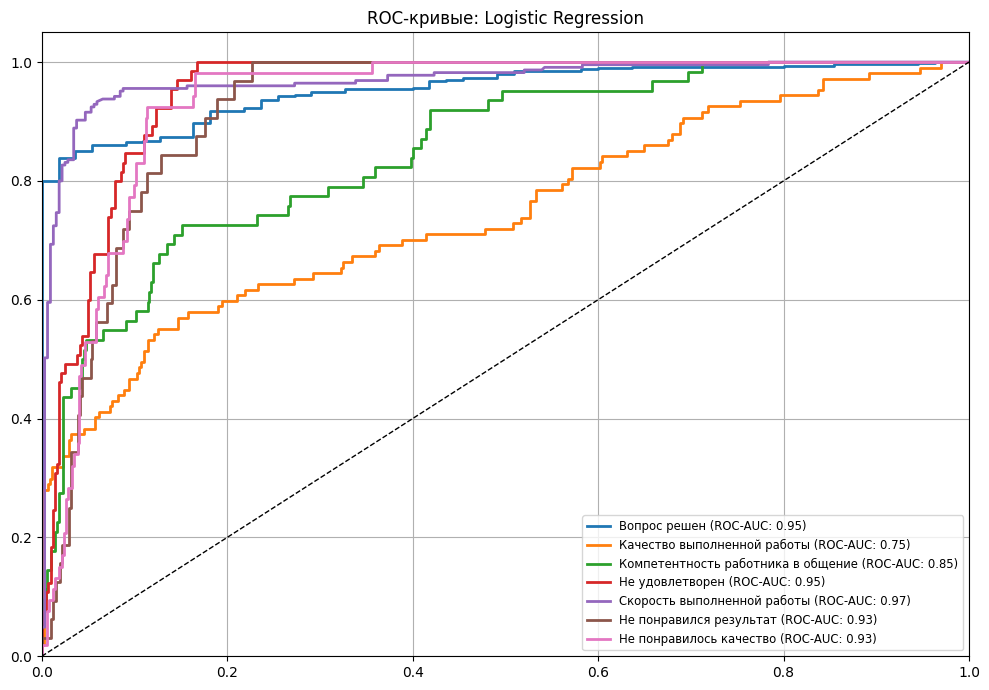

['model/logistic_model.pkl']

In [70]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc as sk_auc
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
import numpy as np
import joblib

# Обучение модели
model = MultiOutputClassifier(LogisticRegression(max_iter=2000, class_weight='balanced'))
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

print("\nLogistic Regression")
print("{:<40} {:>10} {:>10}".format("Label", "ROC-AUC", "F1"))
print("-" * 65)
roc_auc_values = []
f1_values = []
labels = []

for i, col in enumerate(y.columns):
    try:
        auc_val = roc_auc_score(y_test[:, i], y_pred[:, i])
        f1 = f1_score(y_test[:, i], y_pred[:, i])
        print(f"{col:<40} {auc_val:>10.3f} {f1:>10.3f}")
        roc_auc_values.append(auc_val)
        f1_values.append(f1)
        labels.append(col)
    except Exception as e:
        print(f"{col:<40} {'error':>10} {'error':>10} - {str(e)}")

if roc_auc_values:
    avg_roc_auc = np.mean(roc_auc_values)
    avg_f1 = np.mean(f1_values)
    print("-" * 65)
    print(f"{'Average ROC-AUC / F1':<40} {avg_roc_auc:>10.3f} {avg_f1:>10.3f}")

# Предсказания вероятностей
y_proba_raw = model.predict_proba(X_test)
y_proba = np.array([proba[:, 1] for proba in y_proba_raw]).T

# График ROC-кривых
plt.figure(figsize=(10, 7))
for i, col in enumerate(y.columns):
    try:
        fpr, tpr, _ = roc_curve(y_test[:, i], y_proba[:, i])
        roc_auc = sk_auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{col} (ROC-AUC: {roc_auc:.2f})')
    except Exception as e:
        print(f"Ошибка ROC-кривой для {col}: {e}")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC-кривые: Logistic Regression')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# Сохранение модели
joblib.dump(model, "model/logistic_model.pkl")


### Random Forest


Random Forest
Label                                       ROC-AUC         F1
-----------------------------------------------------------------
Вопрос решен                                  0.562      0.951
Качество выполненной работы                   0.656      0.470
Компетентность работника в общение            0.579      0.270
Не удовлетворен                               0.611      0.357
Скорость выполненной работы                   0.913      0.901
Не понравился результат                       0.516      0.061
Не понравилось качество                       0.519      0.073
-----------------------------------------------------------------
Average ROC-AUC / F1                          0.622      0.440


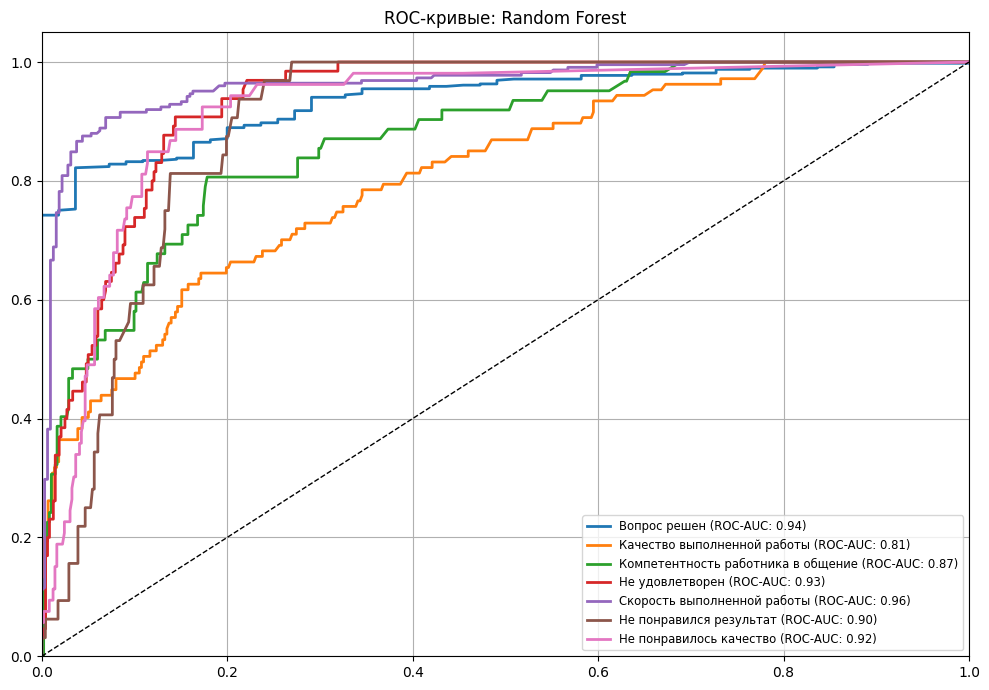

['model/random_forest_model.pkl']

In [71]:
rf_model = MultiOutputClassifier(RandomForestClassifier(n_estimators=1000, random_state=42))
rf_model.fit(X_train, y_train)

# Предсказания
y_pred_rf = rf_model.predict(X_test)

print("\nRandom Forest")
print("{:<40} {:>10} {:>10}".format("Label", "ROC-AUC", "F1"))
print("-" * 65)
roc_auc_values_rf = []
f1_values_rf = []
labels_rf = []

for i, col in enumerate(y.columns):
    try:
        auc_val = roc_auc_score(y_test[:, i], y_pred_rf[:, i])
        f1 = f1_score(y_test[:, i], y_pred_rf[:, i])
        print(f"{col:<40} {auc_val:>10.3f} {f1:>10.3f}")
        roc_auc_values_rf.append(auc_val)
        f1_values_rf.append(f1)
        labels_rf.append(col)
    except Exception as e:
        print(f"{col:<40} {'error':>10} {'error':>10} - {str(e)}")

if roc_auc_values_rf:
    avg_roc_auc_rf = np.mean(roc_auc_values_rf)
    avg_f1_rf = np.mean(f1_values_rf)
    print("-" * 65)
    print(f"{'Average ROC-AUC / F1':<40} {avg_roc_auc_rf:>10.3f} {avg_f1_rf:>10.3f}")

# Предсказания вероятностей
y_proba_raw_rf = rf_model.predict_proba(X_test)
y_proba_rf = np.array([proba[:, 1] for proba in y_proba_raw_rf]).T

# График ROC-кривых
plt.figure(figsize=(10, 7))
for i, col in enumerate(y.columns):
    try:
        fpr, tpr, _ = roc_curve(y_test[:, i], y_proba_rf[:, i])
        roc_auc = sk_auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{col} (ROC-AUC: {roc_auc:.2f})')
    except Exception as e:
        print(f"Ошибка ROC-кривой для {col}: {e}")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC-кривые: Random Forest')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# Сохранение модели
joblib.dump(rf_model, "model/random_forest_model.pkl")


### Linear SVC


Linear SVC
Label                                       ROC-AUC         F1
-----------------------------------------------------------------
Вопрос решен                                  0.605      0.954
Качество выполненной работы                   0.681      0.526
Компетентность работника в общение            0.658      0.471
Не удовлетворен                               0.643      0.421
Скорость выполненной работы                   0.903      0.890
Не понравился результат                       0.529      0.111
Не понравилось качество                       0.571      0.246
-----------------------------------------------------------------
Average ROC-AUC / F1                          0.656      0.517


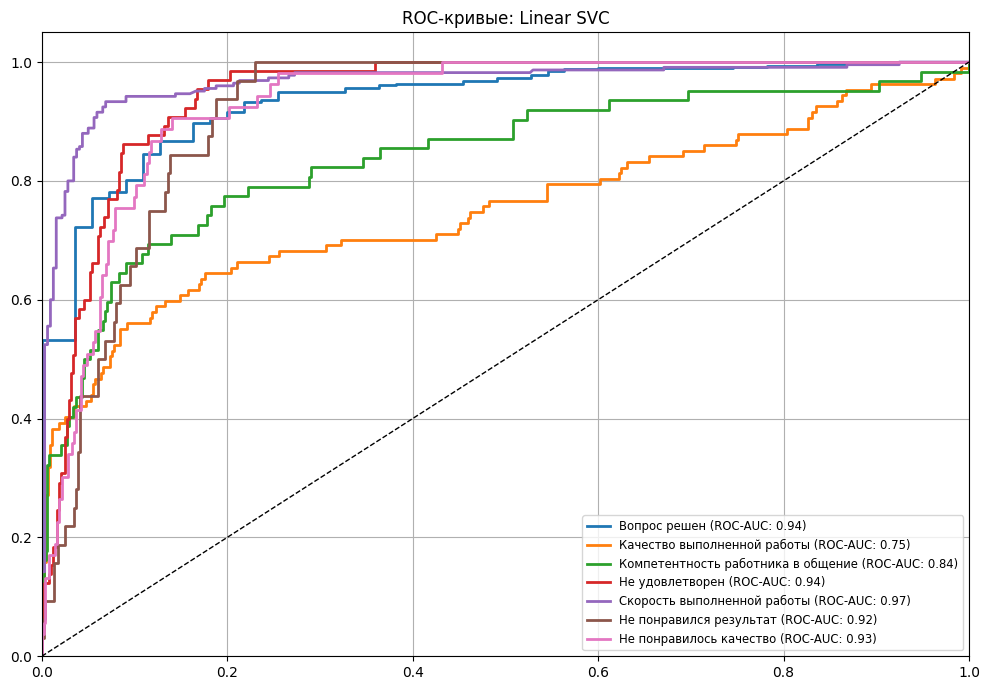

['model/linear_svc_model.pkl']

In [72]:
svc_model = OneVsRestClassifier(LinearSVC(max_iter=10000))
svc_model.fit(X_train, y_train)

# Предсказания
y_pred_svc = svc_model.predict(X_test)

print("\nLinear SVC")
print("{:<40} {:>10} {:>10}".format("Label", "ROC-AUC", "F1"))
print("-" * 65)
roc_auc_values_svc = []
f1_values_svc = []
labels_svc = []

for i, col in enumerate(y.columns):
    try:
        auc_val = roc_auc_score(y_test[:, i], y_pred_svc[:, i])
        f1 = f1_score(y_test[:, i], y_pred_svc[:, i])
        print(f"{col:<40} {auc_val:>10.3f} {f1:>10.3f}")
        roc_auc_values_svc.append(auc_val)
        f1_values_svc.append(f1)
        labels_svc.append(col)
    except Exception as e:
        print(f"{col:<40} {'error':>10} {'error':>10} - {str(e)}")

if roc_auc_values_svc:
    avg_roc_auc_svc = np.mean(roc_auc_values_svc)
    avg_f1_svc = np.mean(f1_values_svc)
    print("-" * 65)
    print(f"{'Average ROC-AUC / F1':<40} {avg_roc_auc_svc:>10.3f} {avg_f1_svc:>10.3f}")

# Получаем decision_function (shape [n_samples, n_classes])
y_scores = svc_model.decision_function(X_test)

# Применяем сигмоиду для перевода в вероятности
y_proba_svc = expit(y_scores)

# График ROC-кривых
plt.figure(figsize=(10, 7))
for i, col in enumerate(y.columns):
    try:
        fpr, tpr, _ = roc_curve(y_test[:, i], y_proba_svc[:, i])
        roc_auc = sk_auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{col} (ROC-AUC: {roc_auc:.2f})')
    except Exception as e:
        print(f"Ошибка ROC-кривой для {col}: {e}")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC-кривые: Linear SVC')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# Сохранение модели
joblib.dump(svc_model, "model/linear_svc_model.pkl")


### CatBoostClassifier


CatBoostClassifier
Label                                       ROC-AUC         F1
-----------------------------------------------------------------
Вопрос решен                                  0.762      0.956
Качество выполненной работы                   0.676      0.492
Компетентность работника в общение            0.728      0.571
Не удовлетворен                               0.743      0.560
Скорость выполненной работы                   0.925      0.914
Не понравился результат                       0.675      0.351
Не понравилось качество                       0.726      0.500
-----------------------------------------------------------------
Average ROC-AUC / F1                          0.748      0.621


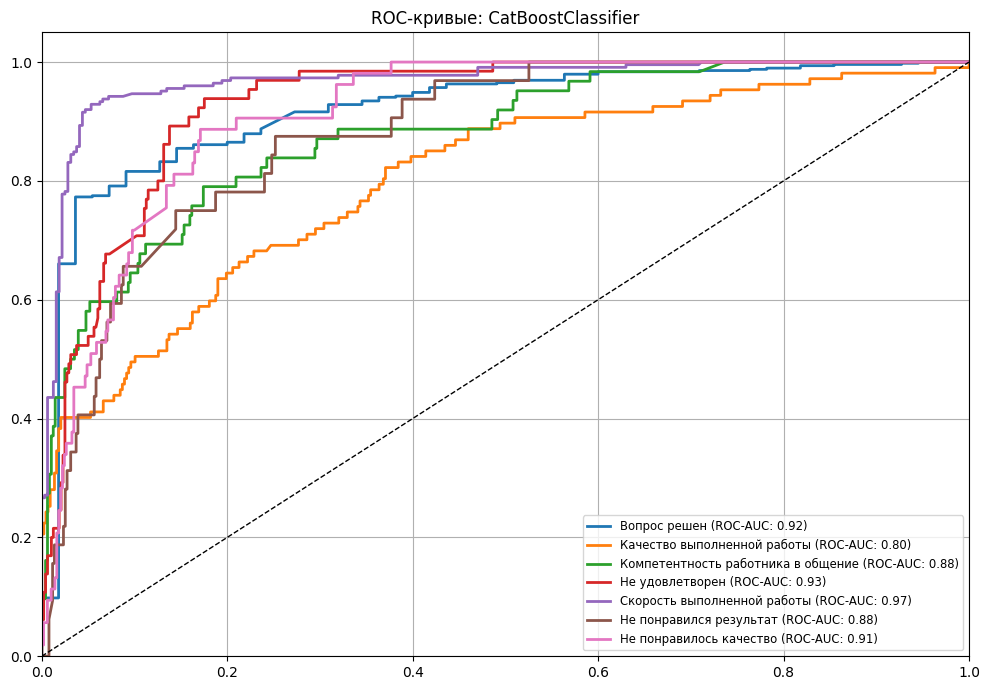

['model/catboost_model.pkl']

In [73]:
base_model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.1,
    depth=6,
    auto_class_weights='Balanced',  # Для борьбы с дисбалансом
    verbose=0
)

# Обёртка для многоклассовой многолейбл задачи
model = MultiOutputClassifier(base_model)

# Обучение
model.fit(X_train, y_train)

# Предсказания (класс)
y_pred = model.predict(X_test)

print("\nCatBoostClassifier")
print("{:<40} {:>10} {:>10}".format("Label", "ROC-AUC", "F1"))
print("-" * 65)
roc_auc_values = []
f1_values = []
labels = []

for i, col in enumerate(y.columns):
    try:
        auc_val = roc_auc_score(y_test[:, i], y_pred[:, i])
        f1 = f1_score(y_test[:, i], y_pred[:, i])
        print(f"{col:<40} {auc_val:>10.3f} {f1:>10.3f}")
        roc_auc_values.append(auc_val)
        f1_values.append(f1)
        labels.append(col)
    except Exception as e:
        print(f"{col:<40} {'error':>10} {'error':>10} - {str(e)}")

if roc_auc_values:
    avg_roc_auc = np.mean(roc_auc_values)
    avg_f1 = np.mean(f1_values)
    print("-" * 65)
    print(f"{'Average ROC-AUC / F1':<40} {avg_roc_auc:>10.3f} {avg_f1:>10.3f}")

# Получаем вероятности для положительного класса
# predict_proba для MultiOutputClassifier возвращает список массивов
y_proba_list = model.predict_proba(X_test)
y_proba = np.array([proba[:, 1] for proba in y_proba_list]).T  # shape: (n_samples, n_classes)

# График ROC-кривых
plt.figure(figsize=(10, 7))
for i, col in enumerate(y.columns):
    try:
        fpr, tpr, _ = roc_curve(y_test[:, i], y_proba[:, i])
        roc_auc = sk_auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{col} (ROC-AUC: {roc_auc:.2f})')
    except Exception as e:
        print(f"Ошибка ROC-кривой для {col}: {e}")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC-кривые: CatBoostClassifier')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# Сохранение модели
joblib.dump(model, "model/catboost_model.pkl")